In [1]:
# Je regroupe les imports en début de notebook
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb # installation : conda install -c conda-forge xgboost

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Jupyter")
os.getcwd()

# Lecture du fichier CSV
data = pd.read_csv("building-energy-model-data_sans_ENERGYSTARScore.csv", sep=',') # séparateur = virgule

In [2]:
print(data.columns.tolist())

['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'age', 'consommation', 'emissions', 'Office', 'Medical Office', 'Other', 'Retail Store', 'Non-Refrigerated Warehouse', 'K-12 School', 'Restaurant', 'Outpatient Rehabilitation/Physical Therapy', 'Automobile Dealership', 'Performing Arts', 'Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Self-Storage Facility', 'Other - Mall', 'Senior Care Community', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Other/Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Multifamily Housing', 'Worship Facility', 'Data Center', 'Laboratory', 'Sup

In [3]:
index_consommation = -1
index_emissions = -1
for i in range(len(data.columns)):
    if data.iloc[:, i].name == 'consommation':
        index_consommation = i
    if data.iloc[:, i].name == 'emissions':
        index_emissions = i
print('index_consommation =', index_consommation, '\nindex_emissions =', index_emissions)

index_consommation = 10 
index_emissions = 11


In [4]:
# On récupère les features d'un côté...
X = pd.concat([data.iloc[:,:index_consommation], data.iloc[:,index_emissions+1:]], axis = 1)

# et les targets de l'autre
y_consommation = data.iloc[:,index_consommation]
y_emissions = data.iloc[:,index_emissions]

print("Données initiales :", data.shape)
print("Features :", X.shape)
print("Targets :", y_consommation.shape, "&", y_emissions.shape)
print(X.columns.tolist(), "\n", y_consommation.head(), "\n", y_emissions.head())

Données initiales : (1687, 119)
Features : (1687, 117)
Targets : (1687,) & (1687,)
['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'age', 'Office', 'Medical Office', 'Other', 'Retail Store', 'Non-Refrigerated Warehouse', 'K-12 School', 'Restaurant', 'Outpatient Rehabilitation/Physical Therapy', 'Automobile Dealership', 'Performing Arts', 'Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Self-Storage Facility', 'Other - Mall', 'Senior Care Community', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Other/Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Multifamily Housing',

On commence par définir nos jeux de données pour le modèle de prédiction de la consommation d'énergie (y_consommation) et on standardise les données.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_consommation, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)

X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

In [6]:
X_train

,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Latitude,Longitude,age,...,BALLARD,MAGNOLIA / QUEEN ANNE,NORTHEAST,NORTH,CENTRAL,SOUTHWEST,DELRIDGE,electricity,natural_gas,steam
575,7,1.0,76.0,319400,1632820,319368.0,0.0,47.60454,-122.33072,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
632,2,1.0,1.0,0,60448,7746.0,0.0,47.51168,-122.28285,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1252,1,1.0,1.0,0,32000,0.0,0.0,47.53160,-122.33300,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,6,1.0,3.0,0,92437,0.0,0.0,47.67725,-122.32232,94,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1004,3,1.0,2.0,0,2200000,318960.0,0.0,47.61065,-122.31711,82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,1,1.0,1.0,0,113780,22248.0,0.0,47.56548,-122.35378,66,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
773,1,1.0,2.0,0,25762,0.0,0.0,47.56197,-122.38109,75,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1520,1,1.0,1.0,0,42420,10000.0,5000.0,47.53326,-122.32579,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
107,4,2.0,4.0,0,50017,0.0,0.0,47.65772,-122.31756,59,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
X_train_std

array([[ 1.1864177 , -0.12345245, 11.1546713 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.08569684, -0.12345245, -0.49740879, ...,  1.        ,
         0.        ,  0.        ],
       [-1.54011974, -0.12345245, -0.49740879, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.54011974, -0.12345245, -0.49740879, ...,  0.        ,
         1.        ,  0.        ],
       [-0.17685102,  0.67337699, -0.03132558, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7319948 , -0.12345245, -0.49740879, ...,  1.        ,
         0.        ,  0.        ]])

Ici on définit une première fonction qui va nous afficher les différentes mesures de qualité d'après les prédictions de nos modèles et une seconde fonction qui va entrainer le modèle du type passé en paramètre, faire des prédictions et appeler la première méthode pour afficher les résultats de ce modèle.

In [8]:
mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

def fit_predict_and_show_metrics(model, Xtrain, Xtest, ytrain, ytest, model_name):
    """
    Réalise l'entrainement du modèle et la prédiction sur les données de test,
    puis calcule les métriques d'évaluation
    """
    tps1 = time.time()
    model.fit(Xtrain, ytrain)
    tps2 = time.time()
    ypred = model.predict(Xtest)
    fit_times[model_name] = tps2 - tps1
    predict_times[model_name] = time.time() - tps2
    mean_absolute_errors[model_name] = mean_absolute_error(ytest, ypred)
    mean_squared_errors[model_name] = mean_squared_error(ytest, ypred)
    root_mean_squared_errors[model_name] = np.sqrt(mean_squared_errors[model_name])
    rmpses[model_name] = np.sqrt(np.mean(np.square(((ytest - ypred) / ytest))))
    mean_absolute_percentage_errors[model_name] = mean_absolute_percentage_error(ytest, ypred)
    r2_scores[model_name] = r2_score(ytest, ypred)
    print("===", model_name, "===")
    print("mean_absolute_error : {:.2f}".format(mean_absolute_errors[model_name]))
    print("mean_squared_error : {:.2f}".format(mean_squared_errors[model_name]))
    print("root_mean_squared_error : {:.2f}".format(root_mean_squared_errors[model_name]))
    print("rmpse : {:.2f}".format(rmpses[model_name]))
    print("mean_absolute_percentage_error : {:.2f}".format(mean_absolute_percentage_errors[model_name]))
    print("r2_score : {:.2f}".format(r2_scores[model_name]))
    print("fit_time : {:.2f}".format(fit_times[model_name]))
    print("predict_time : {:.2f}\n".format(predict_times[model_name]))

On commence par entrainer un modèle "Dummy" (qui renvoie toujours la médiane) afin d'avoir une base de comparaison des autres résultats

In [9]:
dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')

=== DummyRegressor ===
mean_absolute_error : 1.01
mean_squared_error : 1.70
root_mean_squared_error : 1.30
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.01
fit_time : 0.00
predict_time : 0.00



Puis on affiche les scores pour un modèle de régression linéaire et ses dérivées Ridge et Lasso :

In [10]:
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')

=== LinearRegression ===
mean_absolute_error : 0.77
mean_squared_error : 3.14
root_mean_squared_error : 1.77
rmpse : 0.10
mean_absolute_percentage_error : 0.05
r2_score : -0.86
fit_time : 0.02
predict_time : 0.00



In [11]:
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')

=== Ridge ===
mean_absolute_error : 0.76
mean_squared_error : 3.33
root_mean_squared_error : 1.82
rmpse : 0.10
mean_absolute_percentage_error : 0.05
r2_score : -0.97
fit_time : 0.00
predict_time : 0.00



In [12]:
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

=== Lasso ===
mean_absolute_error : 1.02
mean_squared_error : 1.69
root_mean_squared_error : 1.30
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.00
fit_time : 0.01
predict_time : 0.00



Pour ces 3 modèles linéaires, on constate que les scores sont "catastrophiques" : moins bons que le modèle Dummy utilisé comme référence.

On va donc tester 3 autres types de modèles non-linéaires : le Gradient, le Random Forest et le Gradient Boosting.

In [13]:
gradient_boosting_regressor = GradientBoostingRegressor(random_state=123)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(random_state=123)
fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.48
mean_squared_error : 0.44
root_mean_squared_error : 0.66
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.74
fit_time : 0.34
predict_time : 0.00

---
=== RandomForestRegressor ===
mean_absolute_error : 0.50
mean_squared_error : 0.47
root_mean_squared_error : 0.69
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.72
fit_time : 1.28
predict_time : 0.01

---
=== XGBRegressor ===
mean_absolute_error : 0.54
mean_squared_error : 0.55
root_mean_squared_error : 0.74
rmpse : 0.05
mean_absolute_percentage_error : 0.04
r2_score : 0.67
fit_time : 0.24
predict_time : 0.00



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [14]:
gradient_boosting_regressor.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

D'après les chiffres obtenus, le modèle du Gradient est le plus performant avec un score R2 de 92%.
Nous allons donc essayer d'afiner ce résultat en modifiant ses paramètres.

In [15]:
def show_best_params_cv(estimator, parameters, X_train, y_train):
    tps1 = time.time()
    print("Nombre de combinaisons de paramètres étudiées :", len(ParameterGrid(parameters)))
    grid_search_cv = GridSearchCV(estimator = estimator, param_grid = parameters, cv = 3, n_jobs=-1)
    grid_search_cv.fit(X_train, y_train)
    print("best estimator :", grid_search_cv.best_estimator_)
    print("best score :", grid_search_cv.best_score_)
    print("best params :", grid_search_cv.best_params_)
    tps2 = time.time()
    print("\nTemps de traitement total :", tps2 - tps1, "secondes")
    
gradient_boosting_regressor_parameters = {
    'learning_rate': [ 0.01, 0.1, 0.2, 0.5 ],
    'subsample'    : [ 0.1, 0.5, 1, 2 ],
    'n_estimators' : [ 50, 100, 500 ],
    'max_depth'    : [ 2, 3, 5, 10 ]
}
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 3.39861806e-01  3.39716815e-01  3.36420226e-01             nan
  4.85950755e-01  4.82047042e-01  4.78628613e-01             nan
  6.82460787e-01  6.82370632e-01  6.69889369e-01             nan
  3.64192319e-01  3.73852146e-01  3.72442764e-01             nan
  5.20444080e-01  5.27727016e-01  5.22910166e-01             nan
  6.99130159e-01  7.12229930e-01  7.00762755e-01             nan
  3.86709223e-01  4.06349908e-01  4.00305963e-01             nan
  5.48250538e-01  5.72744956e-01  5.62025503e-01             nan
  7.13365468e-01  7.23018312e-01  7.06701117e-01             nan
  4.01250323e-01  4.34118452e-01  4.29744952e-01             nan
  5.65013777e-01  6.01694163e-01  5.84363897e-01             nan
  7.20761483e-01  7.13350376e-01  6.70728817e-01             nan
  6.46832729e-01  6.81354043e-01  6.73887225e-01             nan
  6.71410020e-01  7.10227

best estimator : GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
best score : 0.7230183120740868
best params : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}

Temps de traitement total : 78.67658829689026 secondes


On ré-exécute le Gradient avec les meilleurs paramètres trouvés sur le jeu de test afin de vérifier son score via la méthode précédente.

In [16]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.48
mean_squared_error : 0.45
root_mean_squared_error : 0.67
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.73
fit_time : 1.75
predict_time : 0.01



On essaie d'affiner les résultats du Random Forest, pour voir s'il dépasse le Gradient avec des meilleurs paramètres.

In [17]:
random_forest_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [18]:
random_forest_parameters = {
    'bootstrap': [True, False],
    'max_depth': [None, 50, 60, 80],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 200, 500]
}
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.69326176 0.69679007 0.69647018
 0.69429819 0.69849268 0.69741116        nan        nan        nan
 0.69229905 0.69362336 0.69315565 0.69229905 0.69362336 0.69315565
        nan        nan        nan 0.6862437  0.68645624 0.68573671
 0.6862437  0.68645624 0.68573671        nan        nan        nan
 0.69326176 0.69679007 0.69647018 0.69429819 0.69849268 0.69741116
        nan        nan        nan 0.69229905 0.69362336 0.69315565
 0.69229905 0.69362336 0.69315565        nan        nan        nan
 0.6862437  0.68645624 0.68573671 0.6862437  0.68645624 0.68573671
        nan        nan        nan 0.69326176 0.69679007 0.69647018
 0.69429819 0.69849268 0.69741116        nan        nan        nan
 0.69229905 0.69362336 0.69315565 0.69229905 0.69362336 0.69315565
        nan        nan        nan 0.6862437  0.68645624 0.68573671

best estimator : RandomForestRegressor(min_samples_split=3, n_estimators=200, random_state=123)
best score : 0.698492675656389
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

Temps de traitement total : 333.289936542511 secondes


In [19]:
random_forest_regressor = RandomForestRegressor(n_estimators=500, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')

=== RandomForestRegressor ===
mean_absolute_error : 0.50
mean_squared_error : 0.48
root_mean_squared_error : 0.69
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.72
fit_time : 7.08
predict_time : 0.08



On regarde l'importance des features pour le Random Forest :

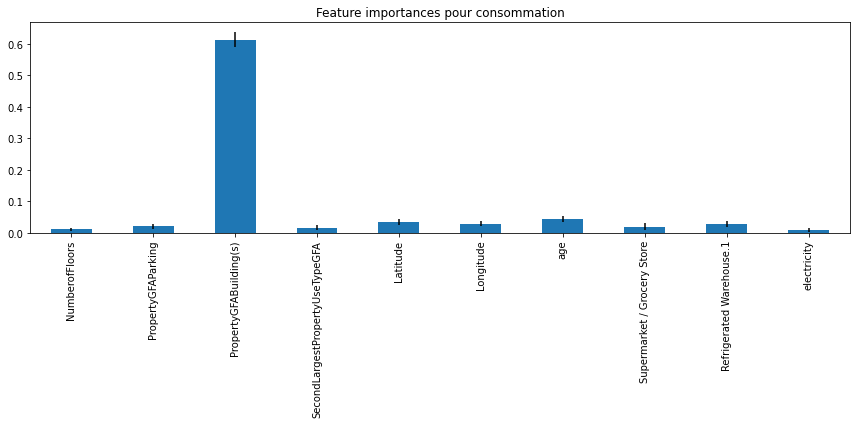

In [20]:
SEUIL = 0.01 # on définit un seuil d'importance

def show_important_features(regressor, columns, label):
    importances = []
    cols = []
    for importance, col in zip(regressor.feature_importances_, columns):
        if importance > SEUIL:
            importances.append(importance)
            cols.append(col)

    estimators_importances = []
    for estimator in regressor.estimators_:
        estimator_importances = []
        for importance, col in zip(estimator.feature_importances_, columns):
            if col in cols:
                estimator_importances.append(importance)
        estimators_importances.append(estimator_importances)
    std = np.std(estimators_importances, axis=0)

    forest_importances = pd.Series(importances, index=cols)

    fig, ax = plt.subplots(figsize=(12,6))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances pour " + label)
    fig.tight_layout()
    
show_important_features(random_forest_regressor, X.columns, "consommation")

On constate que le nombre d'étage et les surfaces des bâtiments sont très importantes pour prédire leur consommation d'énergie, mais également l'âge du bâtiment et sa position géographique. Certains types de bâtiments semblent également déterminer la consommation.

In [21]:
print(X.columns.tolist())

['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'age', 'Office', 'Medical Office', 'Other', 'Retail Store', 'Non-Refrigerated Warehouse', 'K-12 School', 'Restaurant', 'Outpatient Rehabilitation/Physical Therapy', 'Automobile Dealership', 'Performing Arts', 'Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Self-Storage Facility', 'Other - Mall', 'Senior Care Community', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Other/Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Multifamily Housing', 'Worship Facility', 'Data Center', 'Laboratory', 'Supermarket/Grocery Store', 'Urg

In [22]:
xgb_regressor.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [23]:
xgb_regressor_parameters = {
    'gamma':[ 0, 0.5, 1 ],
    'learning_rate': [ .05, .1, .3 ],
    'max_depth': [ 2, 6, 10 ],
    'min_child_weight': [ 1, 5, 10 ],
    'subsample': [ 0.5, 1, 2 ],
    'colsample_bytree': [ 0.5, 1, 2 ],
    'n_estimators': [ 50, 100, 200 ]
}
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 2187


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.15976783 -0.15823549         nan ...         nan         nan
         nan]
  warnings.warn(


best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.7296670299425871
best params : {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1}

Temps de traitement total : 624.2187986373901 secondes


In [24]:
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=5, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

=== XGBRegressor ===
mean_absolute_error : 0.48
mean_squared_error : 0.45
root_mean_squared_error : 0.67
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.73
fit_time : 0.67
predict_time : 0.01



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Comparaison des scores obtenus pour chaque modèle

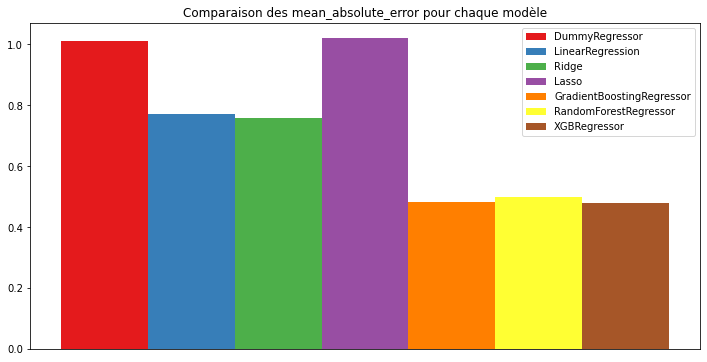

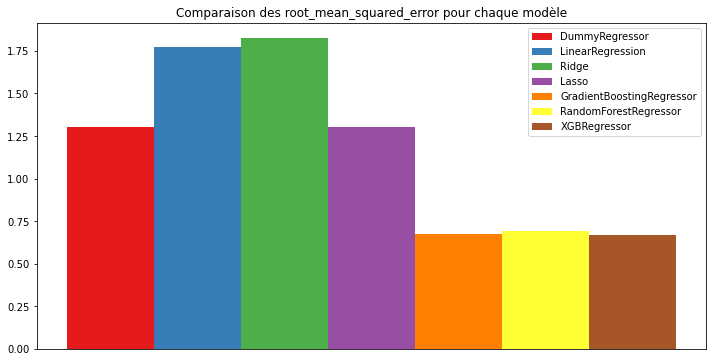

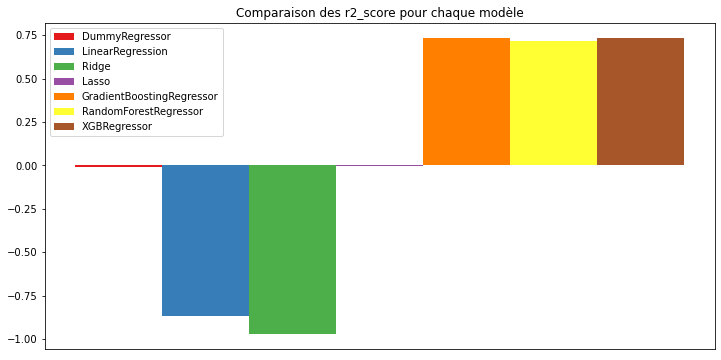

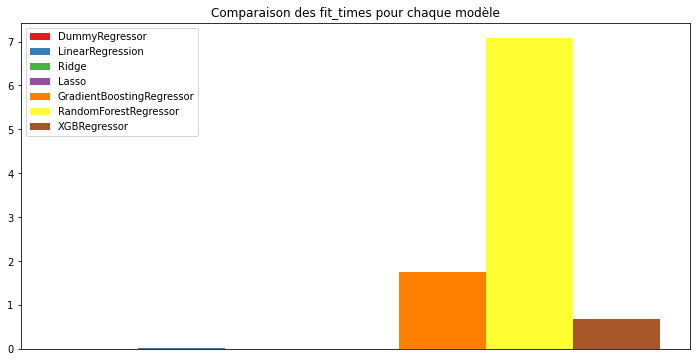

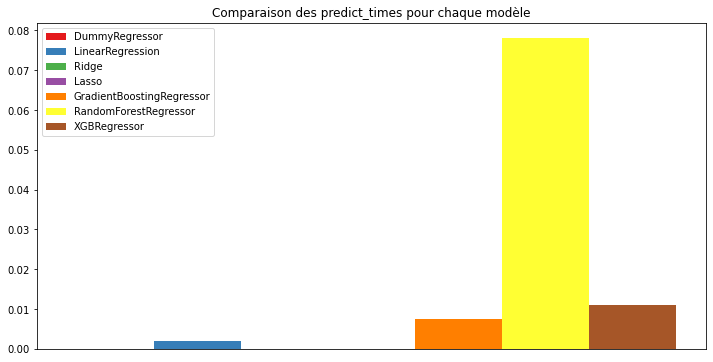

In [25]:
metrics = {
    'mean_absolute_error': mean_absolute_errors,
    'root_mean_squared_error': root_mean_squared_errors,
    'r2_score': r2_scores,
    'fit_times': fit_times,
    'predict_times': predict_times
}
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()


On refait maintenant l'exercice avec la seconde target : les émissions de gaz à effet de serre.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_emissions, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)
X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')
print("---")
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')
print("---")
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')
print("---")
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

=== DummyRegressor ===
mean_absolute_error : 1.23
mean_squared_error : 2.63
root_mean_squared_error : 1.62
rmpse : 4.09
mean_absolute_percentage_error : 1.00
r2_score : -0.00
fit_time : 0.00
predict_time : 0.00

---
=== LinearRegression ===
mean_absolute_error : 0.96
mean_squared_error : 4.24
root_mean_squared_error : 2.06
rmpse : 2.63
mean_absolute_percentage_error : 0.66
r2_score : -0.61
fit_time : 0.01
predict_time : 0.01

---
=== Ridge ===
mean_absolute_error : 0.96
mean_squared_error : 4.49
root_mean_squared_error : 2.12
rmpse : 2.67
mean_absolute_percentage_error : 0.67
r2_score : -0.71
fit_time : 0.00
predict_time : 0.00

---
=== Lasso ===
mean_absolute_error : 1.24
mean_squared_error : 2.63
root_mean_squared_error : 1.62
rmpse : 4.12
mean_absolute_percentage_error : 1.01
r2_score : -0.00
fit_time : 0.00
predict_time : 0.00



In [27]:
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 2.66156670e-01  2.77030917e-01  2.76884506e-01             nan
  3.89523866e-01  4.01207250e-01  3.96056890e-01             nan
  5.81713694e-01  5.95777321e-01  5.84735393e-01             nan
  2.95111458e-01  3.21841838e-01  3.20912102e-01             nan
  4.29800730e-01  4.57065341e-01  4.59356227e-01             nan
  6.00675596e-01  6.22990855e-01  6.13122947e-01             nan
  3.20408047e-01  3.57653268e-01  3.61932927e-01             nan
  4.62038014e-01  4.99505431e-01  5.00607429e-01             nan
  6.14010874e-01  6.28341132e-01  6.15537085e-01             nan
  3.31538999e-01  3.80334253e-01  3.89458739e-01             nan
  4.75718829e-01  5.21868832e-01  5.15043210e-01             nan
  6.19049924e-01  6.13435542e-01  5.70270518e-01             nan
  5.39969119e-01  5.95873769e-01  5.86097793e-01             nan
  5.64532357e-01  6.23623

best estimator : GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
best score : 0.6283411318138509
best params : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}

Temps de traitement total : 76.8165283203125 secondes
Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.59671964 0.59827289 0.59926298
 0.59585487 0.59860195 0.60002692        nan        nan        nan
 0.58489395 0.58584239 0.58805575 0.58489395 0.58584239 0.58805575
        nan        nan        nan 0.57745692 0.58147097 0.58415678
 0.57745692 0.58147097 0.58415678        nan        nan        nan
 0.59671964 0.59827289 0.59926298 0.59585487 0.59860195 0.60002692
        nan        nan        nan 0.58489395 0.58584239 0.58805575
 0.58489395 0.58584239 0.58805575        nan        nan        nan
 0.57745692 0.58147097 0.58415678 0.57745692 0.58147097 0.58415678
        nan        nan        nan 0.59671964 0.59827289 0.59926298
 0.59585487 0.59860195 0.60002692        nan        nan        nan
 0.58489395 0.58584239 0.58805575 0.58489395 0.58584239 0.58805575
        nan        nan        nan 0.57745692 0.58147097 0.58415678

best estimator : RandomForestRegressor(min_samples_split=3, n_estimators=500, random_state=123)
best score : 0.6000269172587854
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}

Temps de traitement total : 325.8914649486542 secondes
Nombre de combinaisons de paramètres étudiées : 2187


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.47700555 0.45775595        nan ...        nan        nan        nan]
  warnings.warn(


best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.6325772076743259
best params : {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}

Temps de traitement total : 680.2219524383545 secondes


In [28]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train_std, X_test_std, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(n_estimators=500, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train_std, X_test_std, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
fit_predict_and_show_metrics(xgb_regressor, X_train_std, X_test_std, y_train, y_test, 'XGBRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.77
mean_squared_error : 1.09
root_mean_squared_error : 1.04
rmpse : 2.23
mean_absolute_percentage_error : 0.56
r2_score : 0.59
fit_time : 4.59
predict_time : 0.01

---
=== RandomForestRegressor ===
mean_absolute_error : 0.79
mean_squared_error : 1.14
root_mean_squared_error : 1.07
rmpse : 2.11
mean_absolute_percentage_error : 0.54
r2_score : 0.57
fit_time : 8.50
predict_time : 0.09

---
=== XGBRegressor ===
mean_absolute_error : 0.76
mean_squared_error : 1.10
root_mean_squared_error : 1.05
rmpse : 2.20
mean_absolute_percentage_error : 0.55
r2_score : 0.58
fit_time : 0.58
predict_time : 0.01



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


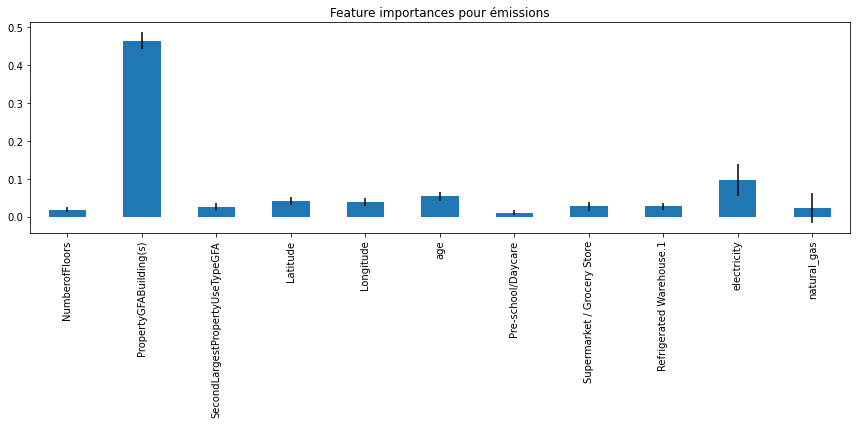

In [29]:
show_important_features(random_forest_regressor, X.columns, "émissions")

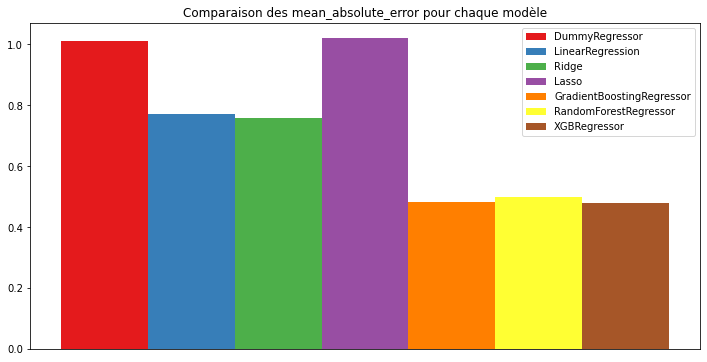

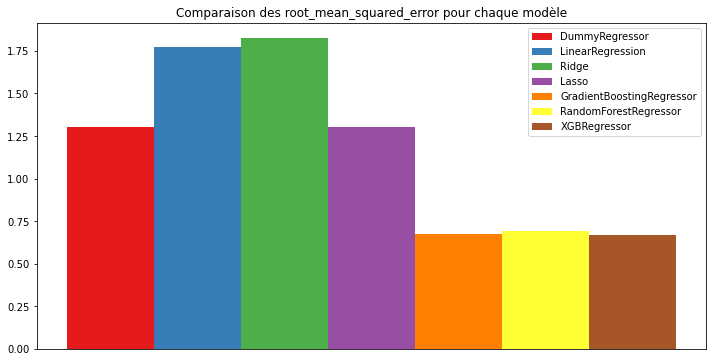

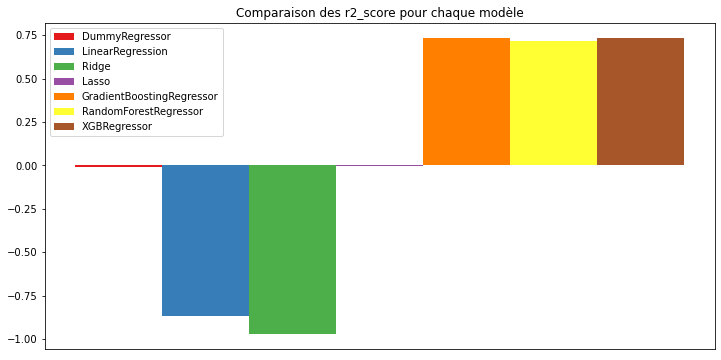

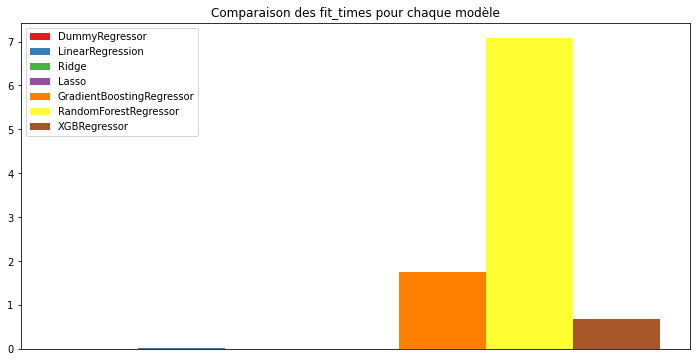

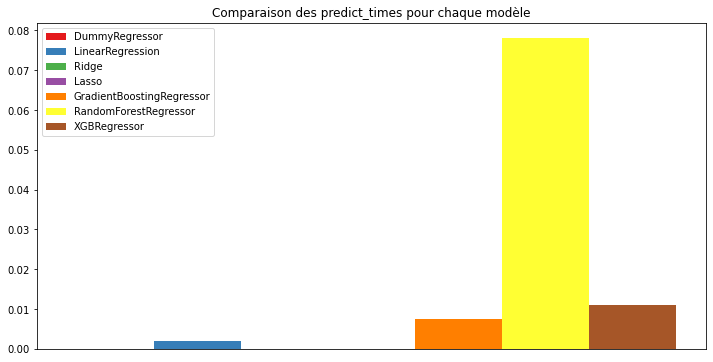

In [30]:
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()